In [1]:
import xarray as xr
import numpy as np
import os
import glob
import pandas as pd
import tensorflow as tf

class GreenEarthNetGenerator:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob.glob(os.path.join(data_dir, "**/*.nc"), recursive=True))
        self.input_days = 50
        self.target_days = 100
        self.s2_bands = ['s2_B02', 's2_B03', 's2_B04', 's2_B8A']
        self.eobs_vars = ['eobs_tg', 'eobs_fg', 'eobs_hu', 'eobs_pp', 'eobs_qq', 'eobs_rr', 'eobs_tn', 'eobs_tx']

        # Normalization stats from en21x_data.py
        self.eobs_stats = {
            'eobs_tg': {'mean': 8.9066, 'std': 9.7562},
            'eobs_fg': {'mean': 2.7329, 'std': 1.4870},
            'eobs_hu': {'mean': 77.5444, 'std': 13.5114},
            'eobs_pp': {'mean': 1014.3310, 'std': 10.2626},
            'eobs_qq': {'mean': 126.4792, 'std': 97.0552},
            'eobs_rr': {'mean': 1.7713, 'std': 4.1480},
            'eobs_tn': {'mean': 4.7707, 'std': 9.0450},
            'eobs_tx': {'mean': 13.5680, 'std': 11.0820}
        }

        self.dem_vars = ['alos_dem', 'cop_dem', 'nasa_dem']

    def compute_ndvi(self, red, nir):
        # NDVI = (NIR - Red) / (NIR + Red)
        denominator = nir + red
        ndvi = np.divide(nir - red, denominator, out=np.zeros_like(denominator), where=denominator!=0)
        # Normalize to [0, 1] as per methodology: [-1, 1] -> [0, 1]
        ndvi_norm = (ndvi + 1) / 2
        return np.clip(ndvi_norm, 0, 1)

    def normalize_band(self, band_data):
        # Simple min-max normalization or percentile based?
        # The previous code used percentile. Let's stick to a robust normalization or just raw for now if not specified.
        # User request didn't specify normalization, but usually it's good practice.
        # However, for a generator "to be used later", raw values might be preferred unless specified.
        # But previous dataset.py had normalization.
        # Let's keep it simple: Raw values for now, or maybe 0-1 if we know the range.
        # Sentinel-2 is usually 0-10000.
        return np.clip(band_data / 10000.0, 0, 1)

    def __call__(self):
        for file_path in self.files:
            try:
                with xr.open_dataset(file_path) as ds:
                    # Check if we have enough time steps
                    if len(ds.time) < self.input_days + self.target_days:
                        continue

                    # --- Inputs (First 50 days) ---
                    input_slice = slice(0, self.input_days)

                    # 1. Sentinel-2 Bands
                    s2_data = []
                    for band in self.s2_bands:
                        b_data = ds[band].isel(time=input_slice).values
                        # Normalize? Let's do simple division by 10000 for S2
                        s2_data.append(np.clip(b_data / 10000.0, 0, 1))

                    # (50, 128, 128, 4)
                    sentinel2 = np.stack(s2_data, axis=-1)

                    # Check for NaNs in Sentinel-2
                    # If any band is NaN, the pixel is missing/invalid
                    s2_nans = np.isnan(sentinel2).any(axis=-1, keepdims=True) # (50, 128, 128, 1)

                    # Replace NaNs with 0.0
                    sentinel2 = np.nan_to_num(sentinel2, nan=0.0)

                    # 2. Cloud Mask
                    # mask > 0 means cloud/shadow etc.
                    mask = ds['s2_mask'].isel(time=input_slice).values
                    s2_mask = (mask > 0).astype(np.float32)
                    s2_mask = np.expand_dims(s2_mask, axis=-1) # (50, 128, 128, 1)

                    # Update mask to include NaNs (missing data)
                    # If s2_nans is True, s2_mask should be 1 (masked)
                    s2_mask = np.maximum(s2_mask, s2_nans.astype(np.float32))

                    # 3. Weather (E-OBS)
                    weather_data = []
                    for var in self.eobs_vars:
                        w_data = ds[var].isel(time=input_slice).values
                        # Normalize
                        stats = self.eobs_stats[var]
                        w_data = (w_data - stats['mean']) / stats['std']
                        weather_data.append(w_data)

                    # (50, 8)
                    weather = np.stack(weather_data, axis=-1)
                    # Handle NaNs in weather if any (though usually E-OBS is complete or interpolated)
                    weather = np.nan_to_num(weather, nan=0.0)

                    # 4. DEM
                    dem_data = []
                    for var in self.dem_vars:
                        d_data = ds[var].values # (lat, lon)
                        # Normalize by dividing by 500
                        d_data = d_data / 500.0
                        dem_data.append(d_data)

                    # (128, 128, 3)
                    dem = np.stack(dem_data, axis=-1)
                    # Handle NaNs in DEM
                    dem = np.nan_to_num(dem, nan=0.0)

                    # 5. Geomorphology
                    geom = ds['geom_cls'].values # (lat, lon)
                    geomorphology = np.expand_dims(geom, axis=-1) # (128, 128, 1)
                    geomorphology = np.nan_to_num(geomorphology, nan=0.0)

                    # 6. Landcover (ESA WorldCover)
                    lc = ds['esawc_lc'].values # (128, 128)

                    # 7. Time
                    times = ds.time.isel(time=input_slice).values
                    ts = pd.to_datetime(times)

                    # Cyclical features for Day of Year
                    doy = ts.dayofyear
                    doy_sin = np.sin(2 * np.pi * doy / 366.0)
                    doy_cos = np.cos(2 * np.pi * doy / 366.0)

                    # Normalize Year (approximate, assuming data is recent)
                    # Let's map 2017-2021 to roughly [-1, 1] or [0, 1]
                    # 2017 is start, 2021 is end.
                    year_norm = (ts.year - 2019) / 2.0

                    time_feats = np.stack([year_norm, doy_sin, doy_cos], axis=-1).astype(np.float32) # (50, 3)

                    x = {
                        'sentinel2': sentinel2.astype(np.float32),
                        's2_mask': s2_mask.astype(np.float32),
                        'weather': weather.astype(np.float32),
                        'dem': dem.astype(np.float32),
                        'geomorphology': geomorphology.astype(np.float32),
                        'time': time_feats
                    }

                    # --- Targets (Next 100 days) ---
                    target_slice = slice(self.input_days+4, self.input_days + self.target_days, 5)

                    red_t = ds['s2_B04'].isel(time=target_slice).values
                    nir_t = ds['s2_B8A'].isel(time=target_slice).values

                    ndvi_t = self.compute_ndvi(red_t, nir_t)

                    # Apply cloud mask
                    mask_t = ds['s2_mask'].isel(time=target_slice).values

                    # Use np.where for safe broadcasting/masking
                    ndvi_t = np.where(mask_t > 0, np.nan, ndvi_t)

                    avail_t = ds['s2_avail'].isel(time=target_slice).values
                    # avail_t is (time,)
                    # Broadcast to (time, 128, 128)
                    avail_t = avail_t[:, None, None]
                    ndvi_t = np.where(avail_t == 0, np.nan, ndvi_t)

                    # Prepare y with shape (20, 128, 128, 2)
                    # Channel 0: NDVI
                    # Channel 1: Landcover (repeated)

                    # Expand NDVI to (20, 128, 128, 1)
                    ndvi_t = np.expand_dims(ndvi_t, axis=-1)

                    # Prepare Landcover (1, 128, 128, 1) -> (20, 128, 128, 1)
                    lc_expanded = np.expand_dims(np.expand_dims(lc, axis=0), axis=-1)
                    lc_t = np.tile(lc_expanded, (ndvi_t.shape[0], 1, 1, 1))

                    y = np.concatenate([ndvi_t, lc_t], axis=-1).astype(np.float32)

                    yield x, y

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    def get_dataset(self) -> tf.data.Dataset:
        # Define output signature
        output_signature = (
            {
                'sentinel2': tf.TensorSpec(shape=(50, 128, 128, 4), dtype=tf.float32),
                's2_mask': tf.TensorSpec(shape=(50, 128, 128, 1), dtype=tf.float32),
                'weather': tf.TensorSpec(shape=(50, 8), dtype=tf.float32),
                'dem': tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
                'geomorphology': tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
                'time': tf.TensorSpec(shape=(50, 3), dtype=tf.float32)
            },
            tf.TensorSpec(shape=(20, 128, 128, 2), dtype=tf.float32)
        )

        return tf.data.Dataset.from_generator(
            self.__call__,
            output_signature=output_signature
        )


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles, name='quantile_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.quantiles = quantiles

    def call(self, y_true, y_pred):
        # y_true: (B, 20, 128, 128, 2) - Channel 0 is NDVI
        # y_pred: (B, NumQuantiles, 20, 128, 128, 1)

        y_true_ndvi = y_true[..., 0:1] # (B, 20, 128, 128, 1)

        # Expand y_true to match y_pred quantiles
        # (B, 1, 20, 128, 128, 1)
        y_true_exp = tf.expand_dims(y_true_ndvi, axis=1)

        # Mask NaNs
        mask = tf.logical_not(tf.math.is_nan(y_true_exp))
        y_true_safe = tf.where(mask, y_true_exp, 0.0)

        loss = 0.0
        for i, q in enumerate(self.quantiles):
            q_pred = y_pred[:, i:i+1, ...] # (B, 1, 20, 128, 128, 1)
            error = y_true_safe - q_pred
            q_loss = tf.maximum(q * error, (q - 1) * error)
            loss += q_loss

        # Apply mask
        loss = tf.where(mask, loss, 0.0)

        # Average over valid pixels
        num_valid = tf.maximum(tf.reduce_sum(tf.cast(mask, tf.float32)), 1.0)
        return tf.reduce_sum(loss) / num_valid

    def get_config(self):
        config = super().get_config()
        config.update({'quantiles': self.quantiles})
        return config

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class VegetationScoreLoss(tf.keras.losses.Loss):
    """
    Vegetation Score Loss.

    Maximizes the Vegetation Score:
    VegScore = 2 - 1/mean(NNSE_veg)
    where NNSE = 1 / (2 - NSE)
    and NSE is Nash-Sutcliffe Efficiency on cloud-free vegetation pixels.

    Loss = 1 - VegScore (to minimize)
         = 1 - (2 - 1/mean(NNSE))
         = 1/mean(NNSE) - 1

    Vegetation classes (ESA WorldCover):
    10: Tree cover
    20: Shrubland
    30: Grassland
    """
    def __init__(self, name='vegetation_score_loss', **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # y_true: (batch, 20, 128, 128, 2) [NDVI, Landcover]
        # y_pred: (batch, 20, 128, 128, 1)

        y_true_ndvi = y_true[..., 0:1]
        landcover = y_true[..., 1:2]

        # Mask for valid pixels (not NaN)
        valid_mask = tf.logical_not(tf.math.is_nan(y_true_ndvi))

        # Mask for vegetation pixels (10, 20, 30)
        # ESA WorldCover: 10=Trees, 20=Shrubland, 30=Grassland
        veg_mask = (landcover == 10) | (landcover == 20) | (landcover == 30)

        # Combined mask: Valid AND Vegetation
        mask = valid_mask & veg_mask

        # Replace NaNs with zeros for calculation
        y_true_safe = tf.where(valid_mask, y_true_ndvi, 0.0)

        # Count valid observations per pixel
        valid_count_per_pixel = tf.reduce_sum(tf.cast(valid_mask, tf.float32), axis=1, keepdims=True) # (B, 1, 128, 128, 1)

        # Sum of true values
        sum_true = tf.reduce_sum(y_true_safe, axis=1, keepdims=True)
        mean_true = tf.math.divide_no_nan(sum_true, valid_count_per_pixel)

        # Numerator: Sum of squared errors
        sse = tf.reduce_sum(tf.square(y_true_safe - y_pred) * tf.cast(valid_mask, tf.float32), axis=1, keepdims=True)

        # Denominator: Sum of squared deviations from mean
        sst = tf.reduce_sum(tf.square(y_true_safe - mean_true) * tf.cast(valid_mask, tf.float32), axis=1, keepdims=True)

        # NSE = 1 - SSE/SST
        epsilon = 1e-6
        nse = 1.0 - (sse / (sst + epsilon))

        # NNSE = 1 / (2 - NSE)
        nnse = 1.0 / (2.0 - nse)

        # Now average NNSE over vegetation pixels
        # veg_mask is (B, 20, 128, 128, 1). We need a spatial mask (B, 1, 128, 128, 1)
        # A pixel is vegetation if it is vegetation at any time step (it's static)
        spatial_veg_mask = veg_mask[:, 0:1, :, :, :] # (B, 1, 128, 128, 1)

        masked_nnse = nnse * tf.cast(spatial_veg_mask, tf.float32)

        sum_nnse = tf.reduce_sum(masked_nnse)
        count_veg = tf.reduce_sum(tf.cast(spatial_veg_mask, tf.float32))

        mean_nnse = tf.math.divide_no_nan(sum_nnse, count_veg)

        # Loss = 1/mean_nnse - 1
        loss = tf.where(
            count_veg > 0,
            (1.0 / (mean_nnse + epsilon)) - 1.0,
            0.0
        )

        return loss

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, quantiles, veg_weight=0.1, name='combined_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.quantiles = quantiles
        self.veg_weight = veg_weight
        self.quantile_loss = QuantileLoss(quantiles)
        self.veg_loss = VegetationScoreLoss()

    def call(self, y_true, y_pred):
        # y_true: (B, 20, 128, 128, 2)
        # y_pred: (B, NumQuantiles, 20, 128, 128, 1)

        # 1. Quantile Loss
        q_loss = self.quantile_loss(y_true, y_pred)

        # 2. Vegetation Score Loss
        # Use the median prediction (usually the middle quantile) for the vegetation score
        # Assuming quantiles are sorted, median is at index len(quantiles)//2
        median_idx = len(self.quantiles) // 2

        # Extract median prediction: (B, NumQuantiles, 20, 128, 128, 1) -> (B, 20, 128, 128, 1)
        # Slicing with integer index removes the dimension
        y_pred_median = y_pred[:, median_idx, ...]

        v_loss = self.veg_loss(y_true, y_pred_median)

        return q_loss + self.veg_weight * v_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            'quantiles': self.quantiles,
            'veg_weight': self.veg_weight
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class QuantileRegressionHead(layers.Layer):
    def __init__(self, forecast_horizon, quantiles, **kwargs):
        super().__init__(**kwargs)
        self.forecast_horizon = forecast_horizon
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        self.quantile_heads = [
            tf.keras.Sequential([
                layers.Conv2D(256, 3, padding='same', activation='relu'),
                layers.Conv2D(128, 3, padding='same', activation='relu'),
                layers.Conv2D(forecast_horizon, 1)
            ], name=f'q_head_{i}')
            for i in range(self.num_quantiles)
        ]

    def call(self, inputs):
        outputs = []
        for head in self.quantile_heads:
            pred = head(inputs)
            pred = tf.transpose(pred, perm=[0, 3, 1, 2]) # (B, 20, 128, 128)
            pred = tf.expand_dims(pred, axis=-1) # (B, 20, 128, 128, 1)
            outputs.append(pred)

        return tf.stack(outputs, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({
            "forecast_horizon": self.forecast_horizon,
            "quantiles": self.quantiles,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable(package="ConvFormer")
class ConvFormer(tf.keras.Model):
    def __init__(self, forecast_horizon=20, quantiles=[0.1, 0.5, 0.9], **kwargs):
        super().__init__(**kwargs)
        self.forecast_horizon = forecast_horizon
        self.quantiles = quantiles

        # --- Encoder ---
        self.spatial_encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu')
        ], name='spatial_encoder')

        self.td_spatial = layers.TimeDistributed(self.spatial_encoder)

        self.conv_lstm = layers.ConvLSTM2D(
            filters=128, kernel_size=3, padding='same', return_sequences=False
        )

        # --- Fusion ---
        self.weather_mlp = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu')
        ], name='weather_mlp')

        self.dem_encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu')
        ], name='dem_encoder')

        self.fusion_conv = layers.Conv2D(256, 3, padding='same', activation='relu')

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(2),
            layers.Conv2D(128, 3, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(64, 3, padding='same', activation='relu')
        ], name='decoder')

        # --- Head ---
        self.head = QuantileRegressionHead(forecast_horizon, quantiles)

    def call(self, inputs):
        if isinstance(inputs, dict):
            sentinel2 = inputs['sentinel2']
            weather = inputs['weather']
            dem = inputs['dem']
        else:
            sentinel2, weather, dem = inputs

        x_spatial = self.td_spatial(sentinel2)
        x_temporal = self.conv_lstm(x_spatial)

        w_feat = tf.reduce_mean(weather, axis=1)
        w_emb = self.weather_mlp(w_feat)
        w_emb = tf.reshape(w_emb, (-1, 1, 1, 128))
        w_emb = tf.tile(w_emb, [1, 32, 32, 1])

        d_emb = self.dem_encoder(dem)

        fused = layers.concatenate([x_temporal, w_emb, d_emb], axis=-1)
        fused = self.fusion_conv(fused)

        decoded = self.decoder(fused)

        outputs = self.head(decoded)

        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "forecast_horizon": self.forecast_horizon,
            "quantiles": self.quantiles,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [7]:
import os
import sys
import argparse
import tensorflow as tf

def train_convformer(
    train_dir,
    val_dir=None,
    batch_size=4,
    epochs=200,
    learning_rate=1e-4,
    checkpoint_dir='checkpoints',
    log_dir='logs/convformer',
    quantiles=[0.1, 0.5, 0.9],
    checkpoint_to_resume=None,
    initial_epoch=0
):
    # Create directories
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    print(f"Loading data from {train_dir}...")

    # 1. Dataset
    generator = GreenEarthNetGenerator(train_dir)
    train_dataset = generator.get_dataset()

    # Shuffle and Batch
    train_dataset = train_dataset.shuffle(100).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

    val_dataset = None
    if val_dir and os.path.exists(val_dir):
        print(f"Loading validation data from {val_dir}...")
        val_generator = GreenEarthNetGenerator(val_dir)
        val_dataset = val_generator.get_dataset()
        val_dataset = val_dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

    # 2. Model - Either load from checkpoint or create new
    if checkpoint_to_resume and os.path.exists(checkpoint_to_resume):
        print(f"Loading model from checkpoint: {checkpoint_to_resume}")
        # Load the full model including optimizer state
        model = tf.keras.models.load_model(
            checkpoint_to_resume,
            custom_objects={
                'ConvFormer': ConvFormer,
                'CombinedLoss': CombinedLoss,
                'QuantileLoss': QuantileLoss
            }
        )
        print("Model loaded successfully. Resuming training...")
        model.summary()
    else:
        if checkpoint_to_resume:
            print(f"Warning: Checkpoint {checkpoint_to_resume} not found. Creating new model...")

        print("Creating ConvFormer model...")
        model = ConvFormer(forecast_horizon=20, quantiles=quantiles)

        # Build model to print summary
        # Create dummy input to build the model
        dummy_input = {
            'sentinel2': tf.zeros((1, 50, 128, 128, 4)),
            's2_mask': tf.zeros((1, 50, 128, 128, 1)),
            'weather': tf.zeros((1, 50, 8)),
            'dem': tf.zeros((1, 128, 128, 3)),
            'geomorphology': tf.zeros((1, 128, 128, 1)),
            'time': tf.zeros((1, 50, 3))
        }
        model(dummy_input)
        model.summary()

        # 3. Compile
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss = CombinedLoss(quantiles=quantiles, veg_weight=0.1)

        model.compile(optimizer=optimizer, loss=loss)

    # 4. Callbacks
    # Save full model (not just weights) to preserve optimizer state
    checkpoint_path = os.path.join(checkpoint_dir, 'convformer_best.keras')

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='loss',
            save_best_only=True,
            save_weights_only=False,  # Save full model including optimizer
            mode='min',
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=25,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    ]

    # 5. Train
    print(f"Starting training from epoch {initial_epoch}...")

    # Calculate steps per epoch
    steps_per_epoch = max(1, len(generator.files) // batch_size)
    validation_steps = None
    if val_dataset is not None and val_dir:
        validation_steps = max(1, len(val_generator.files) // batch_size)

    print(f"Steps per epoch: {steps_per_epoch}")
    if validation_steps:
        print(f"Validation steps: {validation_steps}")

    try:
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            initial_epoch=initial_epoch,
            callbacks=callbacks
        )
    except KeyboardInterrupt:
        print("Training interrupted.")
        return model

    # Save final model (full model with optimizer state)
    final_model_path = os.path.join(checkpoint_dir, 'convformer_final.keras')
    print(f"Saving final model to {final_model_path}...")
    model.save(final_model_path)

    del model
    K.clear_session()

    print("Training complete.")

In [5]:
PRE_TRAINING_EPOCHS=500
FINAL_TRAINING_EPOCHS=1500

In [6]:
train_convformer(
    train_dir="/content/greenearthnet",
    val_dir=None,
    batch_size=4,
    epochs=PRE_TRAINING_EPOCHS,
    learning_rate=1e-3,
    checkpoint_dir="/content/checkpoints",
    log_dir="/content/logs"
)

Loading data from /content/greenearthnet...
Creating ConvFormer model...


Model: "conv_former"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_encoder (Sequential)    │ (1, 32, 32, 128)       │        93,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (1, 50, 32, 32, 128)   │        93,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (1, 32, 32, 128)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_mlp (Sequential)        │ (1, 128)               │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dem_encoder (Sequential)        │ (1, 32, 32, 128)       │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (1, 32, 32, 256)       │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (1, 128, 128, 64)      │       368,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantile_regression_head        │ ?                      │     1,335,996 │
│ (QuantileRegressionHead)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,965,660 (15.13 MB)

 Trainable params: 3,965,660 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

Starting training from epoch 0...
Steps per epoch: 1
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - loss: 75.8596
Epoch 1: loss improved from inf to 75.85962, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step - loss: 75.8596 - learning_rate: 0.0010
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 20.7404
Epoch 2: loss improved from 75.85962 to 20.74045, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 20.7404 - learning_rate: 0.0010
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 137.9860
Epoch 3: loss did not improve from 20.74045
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 137.9860 - learning_rate: 0.0010
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.3987
Epoch 4: loss improved from 20.74045 to 6.39867, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 6.3987 - learning_rate: 0.0010
Epoch 5/500
1/1 

UnboundLocalError: cannot access local variable 'model' where it is not associated with a value

# Visualization

In [8]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = '/content/greenearthnet'
NUM_SAMPLES = 4

def visualize_best_model():

  generator = GreenEarthNetGenerator(DATA_DIR)
  dataset = generator.get_dataset()

  # Take 5 samples
  samples = []
  for x, y in dataset.take(NUM_SAMPLES):
      samples.append((x, y))

  print(f"Loaded {len(samples)} samples.")


  CHECKPOINT_PATH = '/content/checkpoints/convformer_best.keras'
  QUANTILES = [0.1, 0.5, 0.9]

  model = ConvFormer(forecast_horizon=20, quantiles=QUANTILES)

  # Build the model by passing a dummy input or calling build
  # The model expects a dict of inputs. We can use one sample to build it.
  dummy_x = samples[0][0]
  # Add batch dimension
  dummy_x_batch = {k: tf.expand_dims(v, 0) for k, v in dummy_x.items()}

  model(dummy_x_batch)

  print(f"Loading weights from {CHECKPOINT_PATH}...")
  try:
      model.load_weights(CHECKPOINT_PATH)
      print("Weights loaded successfully.")
  except Exception as e:
      print(f"Error loading weights: {e}")
      print("Make sure you have trained the model and the checkpoint exists.")



  def plot_sample(x, y_true, y_pred, sample_idx):
      # y_true: (20, 128, 128)
      # y_pred: (n_quantile, 20, 128, 128)

      # Extract median prediction (q=0.5, idx=1)
      pred_median = y_pred[1] # (20, 128, 128)

      # Select time steps to visualize (e.g., start, middle, end)
      time_steps = [0, 5, 10]

      fig, axes = plt.subplots(2, 3, figsize=(15, 10))
      fig.suptitle(f'Sample {sample_idx+1}', fontsize=16)

      for i, t in enumerate(time_steps):
          # Ground Truth
          ax_gt = axes[0, i]
          im_gt = ax_gt.imshow(y_true[t], cmap='RdYlGn', vmin=0, vmax=1)
          ax_gt.set_title(f'Ground Truth (t={t})')
          ax_gt.axis('off')
          plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)

          # Prediction
          ax_pred = axes[1, i]
          im_pred = ax_pred.imshow(pred_median[t], cmap='RdYlGn', vmin=0, vmax=1)
          ax_pred.set_title(f'Prediction q=0.5 (t={t})')
          ax_pred.axis('off')
          plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

      plt.tight_layout()
      plt.show()

      # Calculate Metrics for this sample
      # Mask NaNs in y_true (if any)
      mask = ~np.isnan(y_true)

      mse = np.mean((y_true[mask] - pred_median[mask])**2)
      mae = np.mean(np.abs(y_true[mask] - pred_median[mask]))

      print(f"Sample {sample_idx+1} Metrics:")
      print(f"  MSE: {mse:.4f}")
      print(f"  MAE: {mae:.4f}")

  # Run prediction and plotting
  for i, (x, y) in enumerate(samples):
      # Add batch dimension
      x_batch = {k: tf.expand_dims(v, 0) for k, v in x.items()}

      # Predict
      y_pred = model(x_batch)

      # Convert to numpy
      y_pred_np = y_pred[0, :, :, :, :, 0].numpy()    # Shape: (3, 20, 128, 128)
      y_true_np = y[:, :, :, 0].numpy()             # Shape: (20, 128, 128)

      plot_sample(x, y_true_np, y_pred_np, i)

Loaded 4 samples.
Loading weights from /content/checkpoints/convformer_best.keras...
Weights loaded successfully.


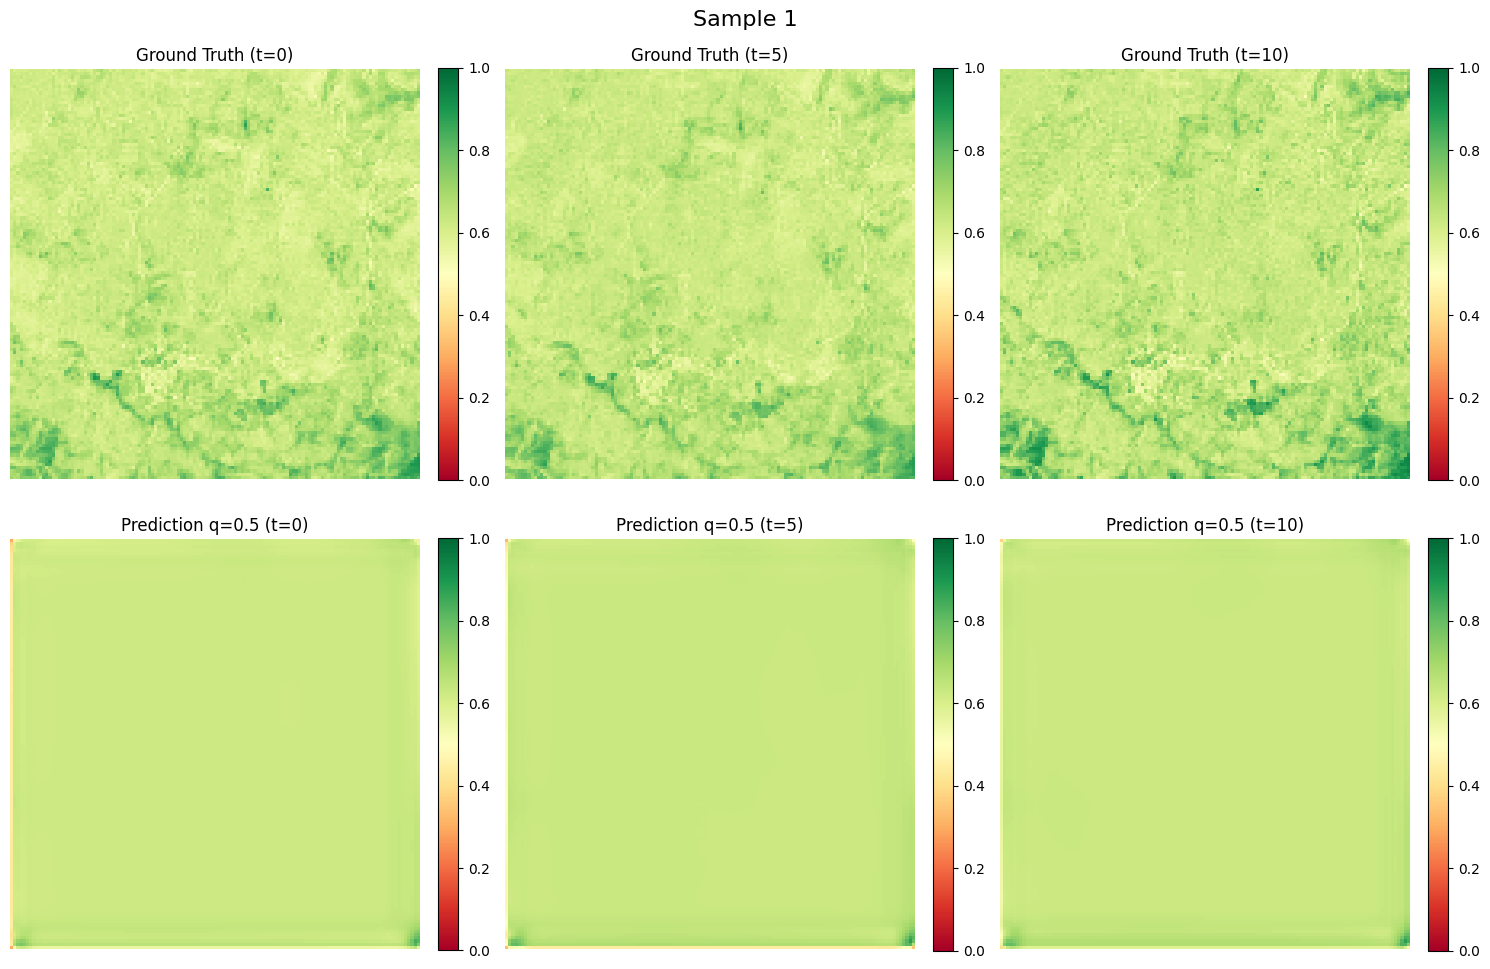

Sample 1 Metrics:
  MSE: 0.0031
  MAE: 0.0362


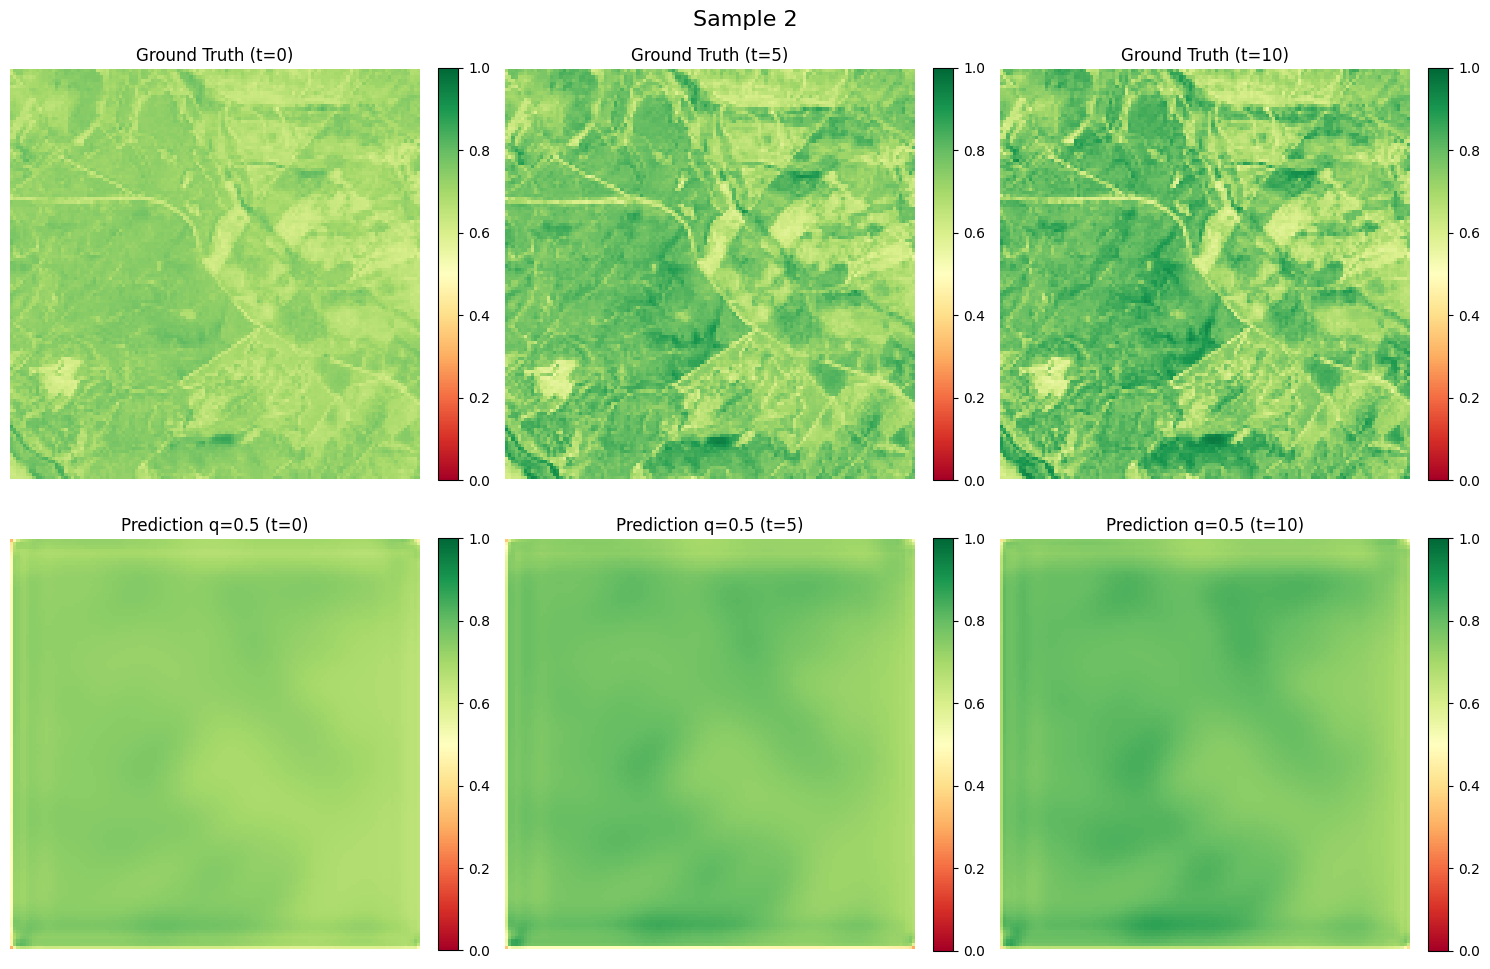

Sample 2 Metrics:
  MSE: 0.0046
  MAE: 0.0498


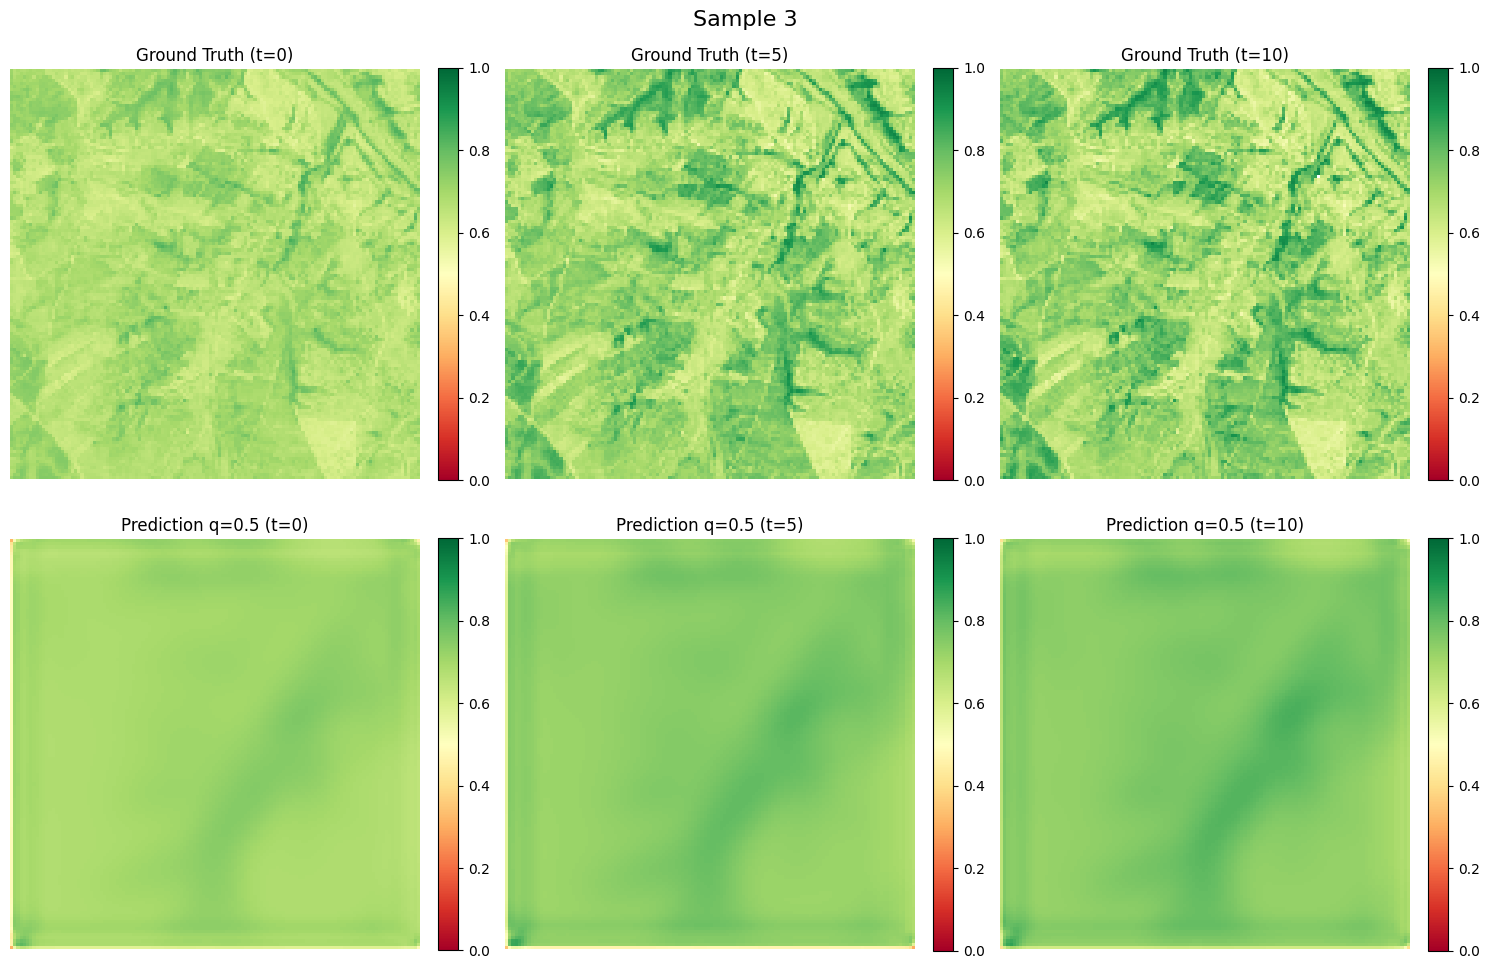

Sample 3 Metrics:
  MSE: 0.0069
  MAE: 0.0667


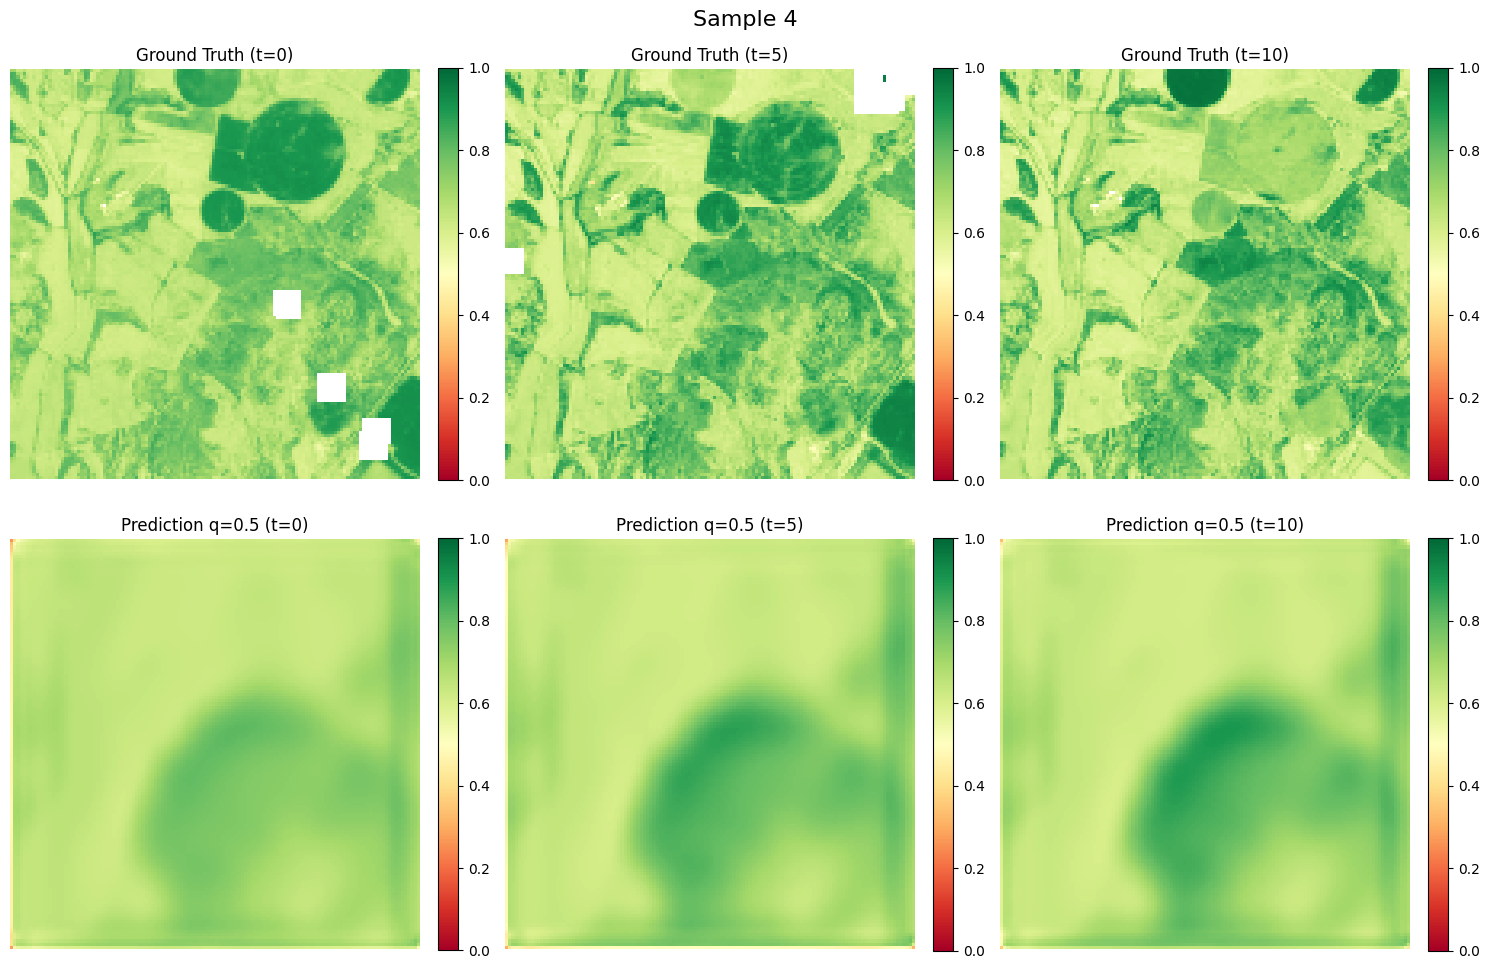

Sample 4 Metrics:
  MSE: 0.0111
  MAE: 0.0753


In [9]:
visualize_best_model()

# Resume Training

In [12]:
RESUME_TRAINING = True

if RESUME_TRAINING:
  train_convformer(
      train_dir="/content/greenearthnet",
      val_dir=None,
      batch_size=4,
      epochs=FINAL_TRAINING_EPOCHS,
      learning_rate=1e-3,
      checkpoint_dir="/content/checkpoints",
      log_dir="/content/logs",
      checkpoint_to_resume="/content/checkpoints/convformer_final.keras",
      initial_epoch=PRE_TRAINING_EPOCHS
  )

Loading data from /content/greenearthnet...
Loading model from checkpoint: /content/checkpoints/convformer_final.keras
Model loaded successfully. Resuming training...


Model: "conv_former"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_encoder (Sequential)    │ (1, 32, 32, 128)       │        93,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (1, 50, 32, 32, 128)   │        93,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (1, 32, 32, 128)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_mlp (Sequential)        │ (1, 128)               │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dem_encoder (Sequential)        │ (1, 32, 32, 128)       │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (1, 32, 32, 256)       │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (1, 128, 128, 64)      │       368,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantile_regression_head_3      │ ?                      │     1,335,996 │
│ (QuantileRegressionHead)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,896,982 (45.38 MB)

 Trainable params: 3,965,660 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,931,322 (30.26 MB)

Starting training from epoch 500...
Steps per epoch: 1
Epoch 501/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - loss: 0.2658
Epoch 501: loss improved from inf to 0.26576, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step - loss: 0.2658 - learning_rate: 1.2500e-04
Epoch 502/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 0.2657
Epoch 502: loss improved from 0.26576 to 0.26570, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2657 - learning_rate: 1.2500e-04
Epoch 503/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2656
Epoch 503: loss improved from 0.26570 to 0.26564, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2656 - learning_rate: 1.2500e-04
Epoch 504/1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2656
Epoch 504: loss improved from 0.26564 to 0.26558, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━

Loaded 4 samples.
Loading weights from /content/checkpoints/convformer_best.keras...
Weights loaded successfully.


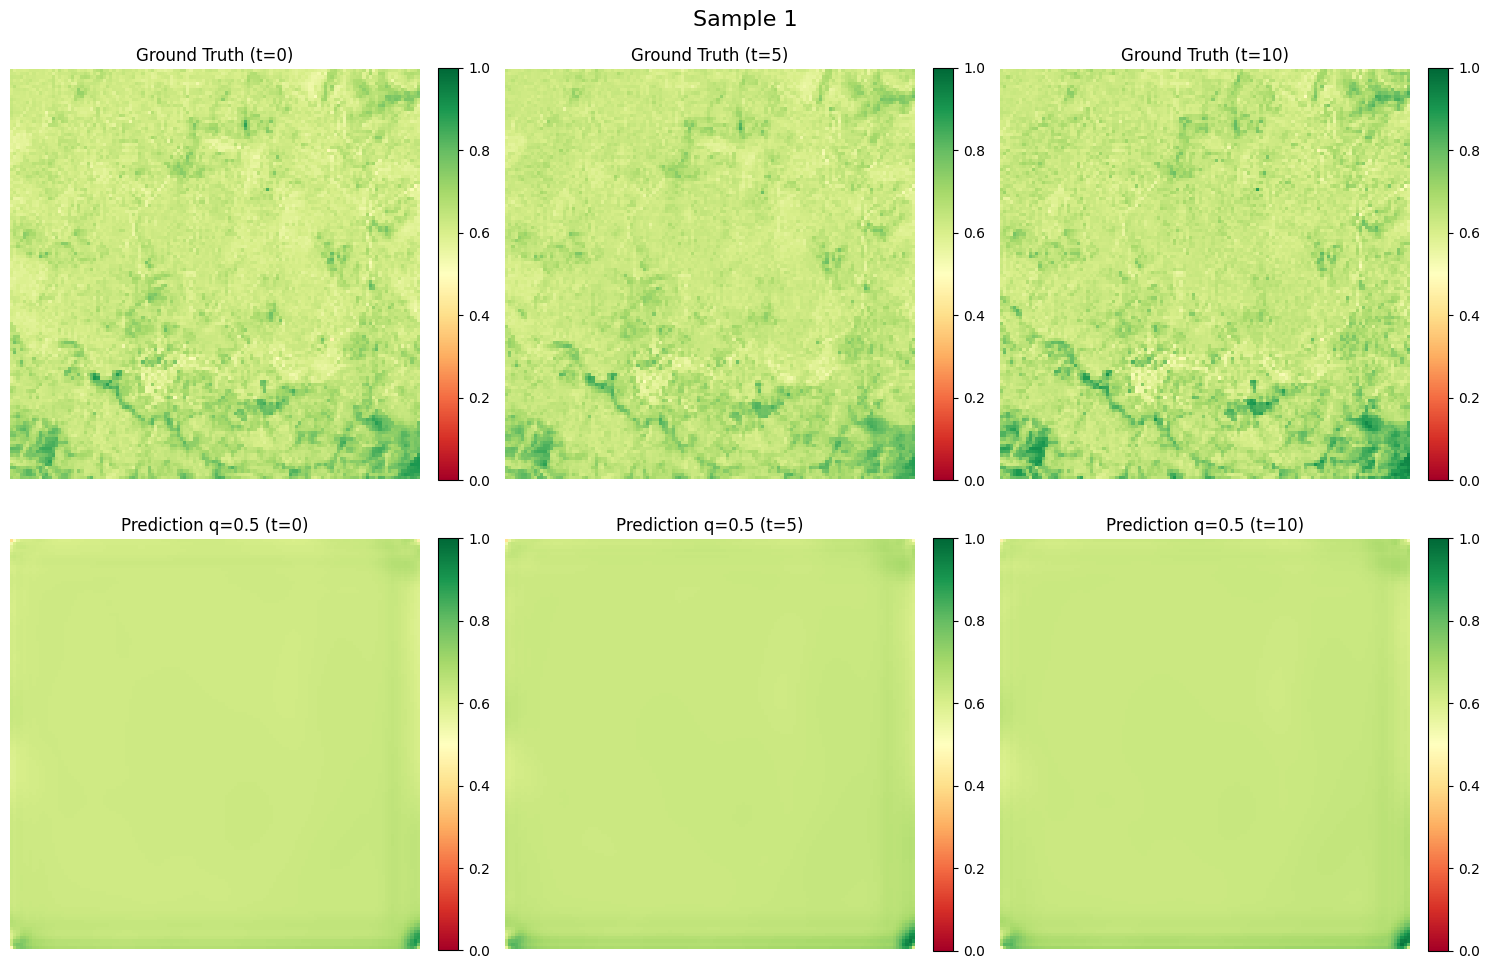

Sample 1 Metrics:
  MSE: 0.0024
  MAE: 0.0330


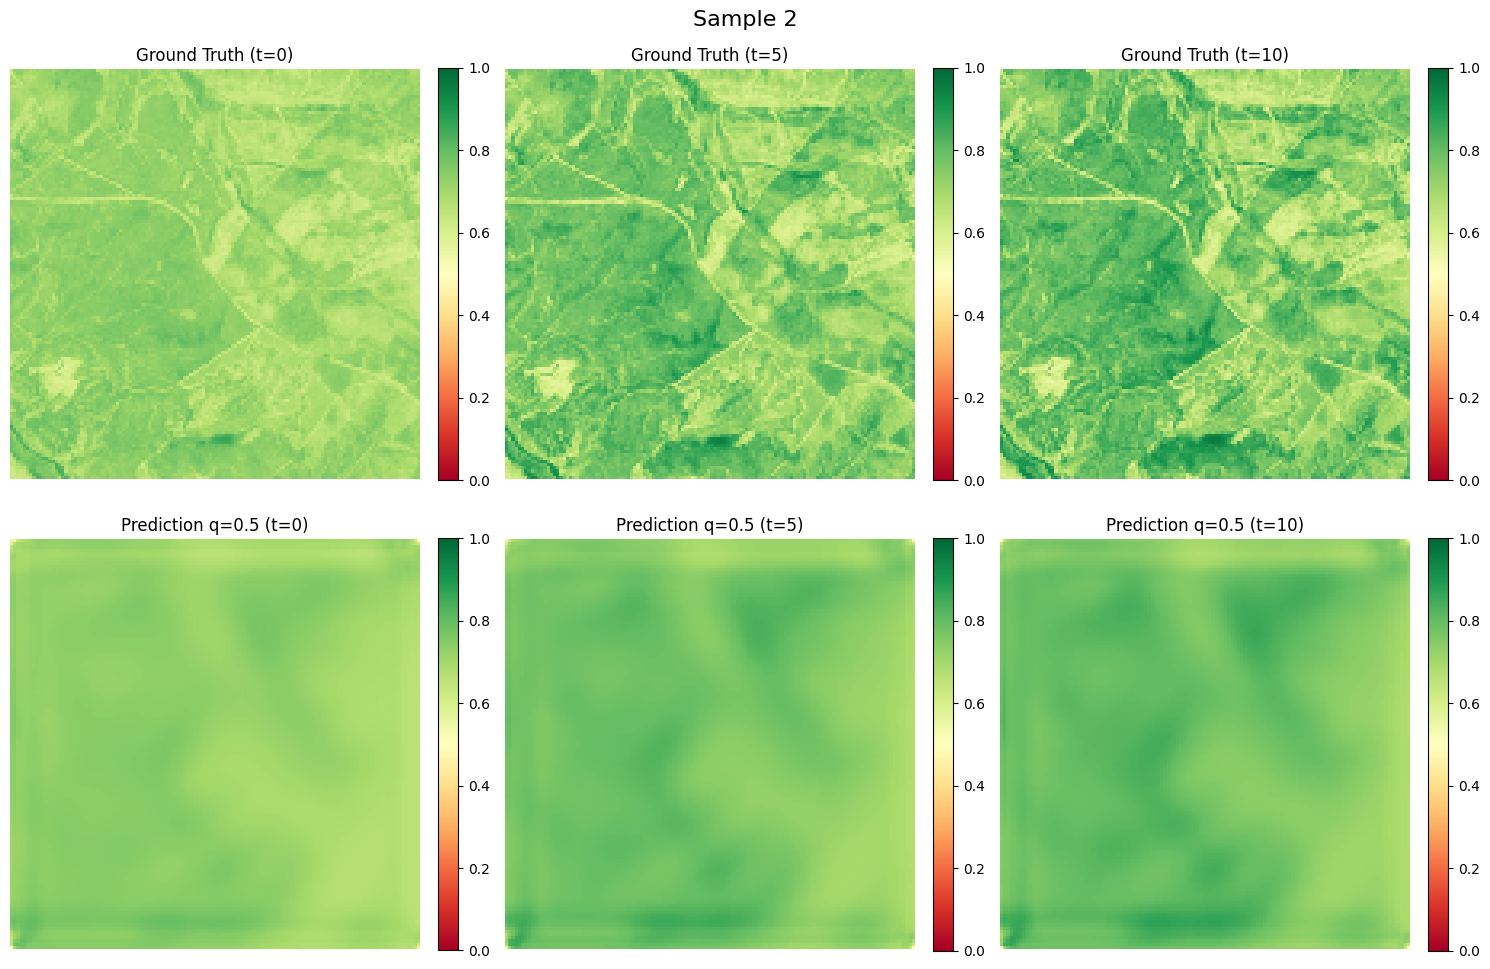

Sample 2 Metrics:
  MSE: 0.0044
  MAE: 0.0486


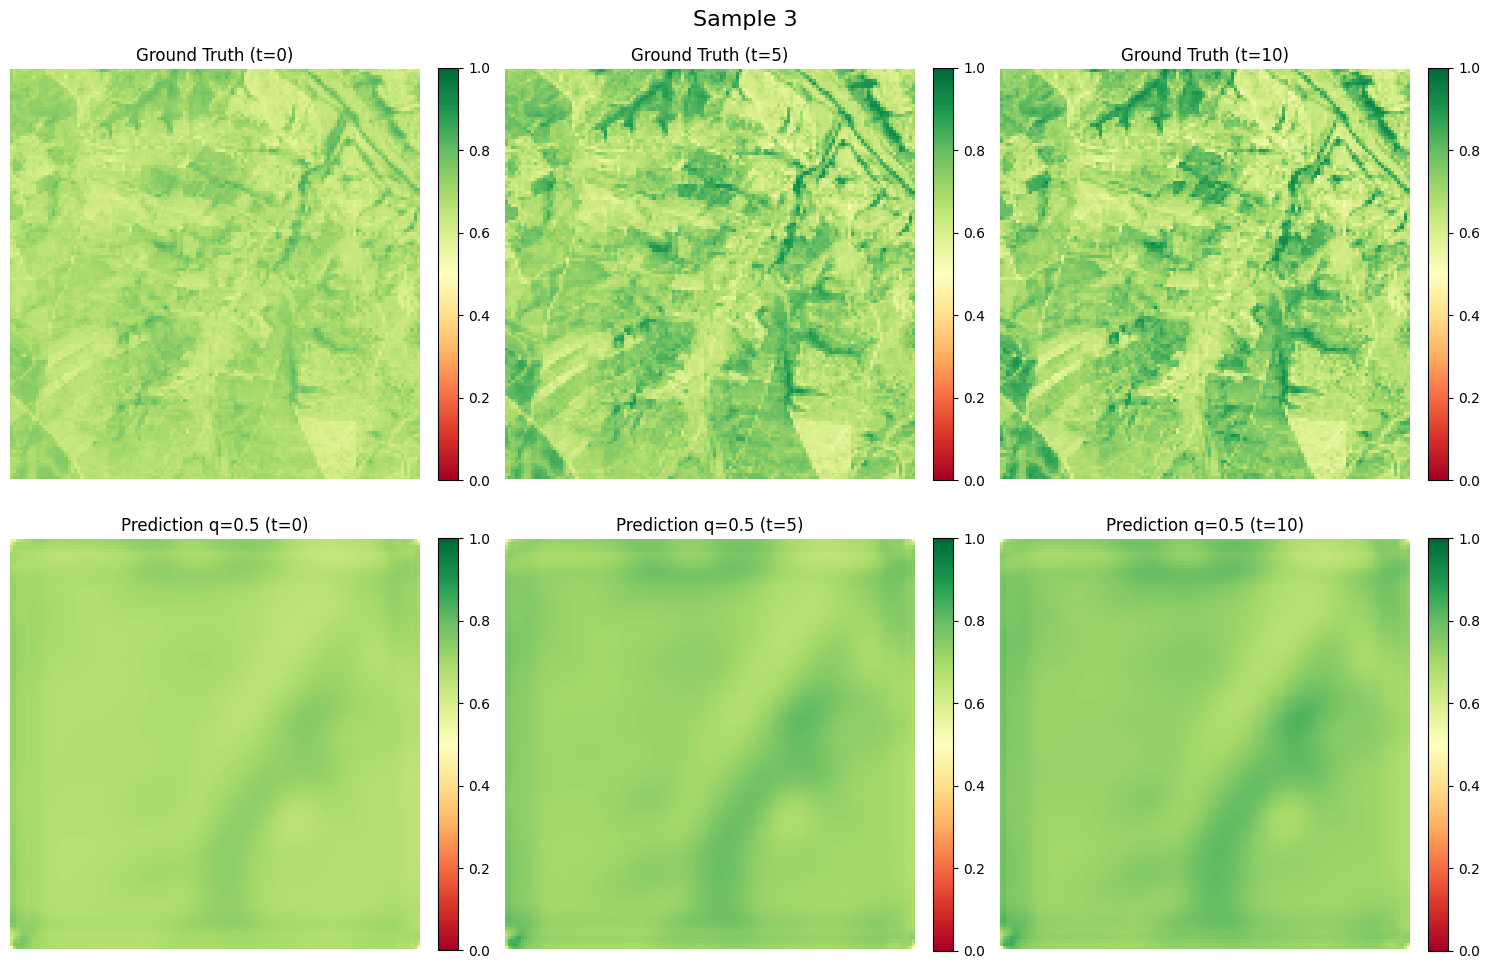

Sample 3 Metrics:
  MSE: 0.0051
  MAE: 0.0569


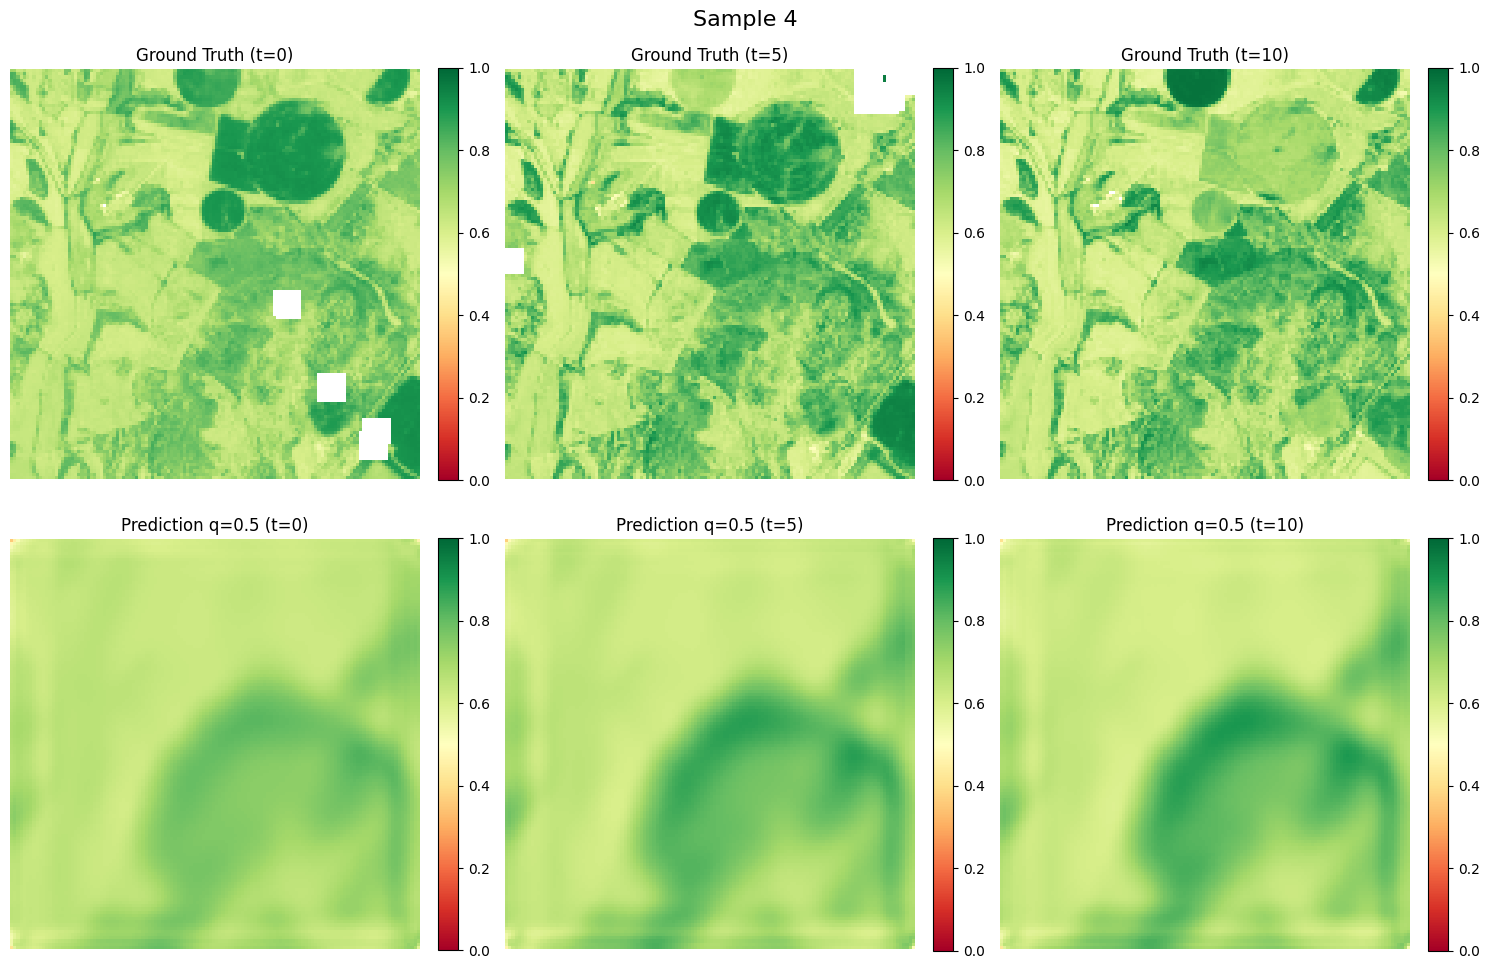

Sample 4 Metrics:
  MSE: 0.0100
  MAE: 0.0688


In [15]:
visualize_best_model()

In [14]:
RESUME_TRAINING = True

if RESUME_TRAINING:
  train_convformer(
      train_dir="/content/greenearthnet",
      val_dir=None,
      batch_size=4,
      epochs=FINAL_TRAINING_EPOCHS*4,
      learning_rate=1e-3,
      checkpoint_dir="/content/checkpoints",
      log_dir="/content/logs",
      checkpoint_to_resume="/content/checkpoints/convformer_final.keras",
      initial_epoch=FINAL_TRAINING_EPOCHS
  )

Loading data from /content/greenearthnet...
Loading model from checkpoint: /content/checkpoints/convformer_final.keras
Model loaded successfully. Resuming training...


Model: "conv_former"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spatial_encoder (Sequential)    │ (1, 32, 32, 128)       │        93,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (1, 50, 32, 32, 128)   │        93,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (1, 32, 32, 128)       │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_mlp (Sequential)        │ (1, 128)               │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dem_encoder (Sequential)        │ (1, 32, 32, 128)       │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (1, 32, 32, 256)       │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (1, 128, 128, 64)      │       368,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantile_regression_head_1      │ ?                      │     1,335,996 │
│ (QuantileRegressionHead)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,896,982 (45.38 MB)

 Trainable params: 3,965,660 (15.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,931,322 (30.26 MB)

Streaming output truncated to the last 5000 lines.
Epoch 1802/6000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - loss: 0.2433
Epoch 1802: loss improved from 0.24332 to 0.24332, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2433 - learning_rate: 1.0000e-07
Epoch 1803/6000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2433
Epoch 1803: loss improved from 0.24332 to 0.24332, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2433 - learning_rate: 1.0000e-07
Epoch 1804/6000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2433
Epoch 1804: loss improved from 0.24332 to 0.24332, saving model to /content/checkpoints/convformer_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2433 - learning_rate: 1.0000e-07
Epoch 1805/6000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - loss: 0.2433
Epoch 1805: loss improved from 0.24332 to 0.24332, saving model to /content/checkpoints/convformer_best.kera